<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Number of Effective Data 


#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Exercise: Spatial Bootstrap for Subsurface Data Analytics in Python 

Here's a simple workflow, demonstration of spatial bootstrap for subsurface modeling workflows. This should help you get started with building subsurface models that integrate uncertainty in the sample statistics.  

#### Bootstrap

Uncertainty in the sample statistics
* one source of uncertainty is the paucity of data.
* do 200 or even less wells provide a precise (and accurate estimate) of the mean? standard deviation? skew? P13?

Would it be useful to know the uncertainty in these statistics due to limited sampling?
* what is the impact of uncertainty in the mean porosity e.g. 20%+/-2%?

**Bootstrap** is a method to assess the uncertainty in a sample statistic by repeated random sampling with replacement.

Assumptions
* sufficient, representative sampling, identical, idependent samples

Limitations
1. assumes the samples are representative 
2. assumes stationarity
3. only accounts for uncertainty due to too few samples, e.g. no uncertainty due to changes away from data
4. does not account for boundary of area of interest 
5. assumes the samples are independent
6. does not account for other local information sources

The **Bootstrap Approach** (Efron, 1982)

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work?  Prove it to yourself, for uncertainty in the mean solution is standard error: 

\begin{equation}
\sigma^2_\overline{x} = \frac{\sigma^2_s}{n}
\end{equation}

Extremely powerful - could calculate uncertainty in any statistic!  e.g. P13, skew etc.
* Would not be possible access general uncertainty in any statistic without bootstrap.
* Advanced forms account for spatial information and sampling strategy (game theory and Journel’s spatial bootstrap (1993).

Steps: 

1. assemble a sample set, must be representative, reasonable to assume independence between samples

2. optional: build a cumulative distribution function (CDF)
    * may account for declustering weights, tail extrapolation
    * could use analogous data to support

3. For $\ell = 1, \ldots, L$ realizations, do the following:

    * For $i = \alpha, \ldots, n$ data, do the following:

        * Draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF (if available). 

6. Calculate a realization of the sammary statistic of interest from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$. Return to 3 for another realization.

7. Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method.  

#### Spatial Bootstrap

Journel (1993) developed methods for spatial bootstrap based on bootstrap resampling accounting for the locations of the data and the spatial continuity model.  

* One method to perform spatial bootstrap for uncertainty of a statistic is to adjust the number of data, $n$, to the **number of effective data**, then use the number of effective data instead of number of data of resamples with replacement for each bootstrap realization.

This number of effectve data may be calculated by:

* building multiple unconditional simulated realizations at the data locations only 

* calculating the variance of the average of each simulated realization

* then calculate the number effective data by manipulating the standard error in the average equation:

\begin{equation}
\sigma^2_\overline{x} = \frac{\sigma^2}{n}
\end{equation}

to be expressed as:

\begin{equation}
n^{'} = \frac{\sigma^2}{\sigma^2_\overline{x}}
\end{equation}


where $\sigma^2_\overline{x}$ is the variance of the average over bootstrap realizations $\ell = 1,\ldots,L$, $\sigma^2$ is the variance / sill of the problem.

#### Simulating Only at the Data Locations

We ultilize LU Simulation to efficiently calculate Gaussian realizations only at the data locations, based on the Lower-Upper Decomposition of the left-hand / redudancy martix of the simple kriging.  

* We multiple the Lower matrix ($n \times n$) with a random Gaussian vector ($1 \times n$) to calculate each realization at the data locations.

* We then take the average of each realization and then calculate the variance of the average over enough realizations.

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [1]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import scipy                              # statistics
import scipy.linalg                       # linear algebra library
import math                               # trig, etc.
import random                             # bootstrap

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
 cmap = plt.cm.inferno

##### Declare Functions

I have included the n_effective function and dependencies here.  I will add this shortly to the GeostatsPy Package.

In [4]:
from numba import jit # for numerical speed up

@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff
    

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [6]:
#os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

* Add a null feature for plotting the data locations, data values are not needed in this calculation / workflow for number of effective data.

In [7]:
#df = pd.read_csv("12_sample_data.csv")                      # read a .csv file in as a DataFrame
df =pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv')
df['null'] = np.zeros(len(df))

Let's drop some samples so that we increase the variations in bootstrap samples for our demonstration below.  

* We will resample 25% of the original data file.  

* I use a random number seed so that we all get the same sample to work with.  

```python 
df.sample(frac = 0.1, random_state = 73073)
```

where *frac* is the fraction to select and *random_state* is the random number seed.

To get different random 25% subset of the data, just drop the 'rand_state' parameter or change the value from '73073' to any other integer.

In [8]:
df = df.sample(frac = 0.1, random_state = 73073)                  # extract 50 random samples to reduce the size of the dataset   
print('Using ' + str(len(df)) + ' number of samples')

Using 48 number of samples


Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We plot the data locations below.

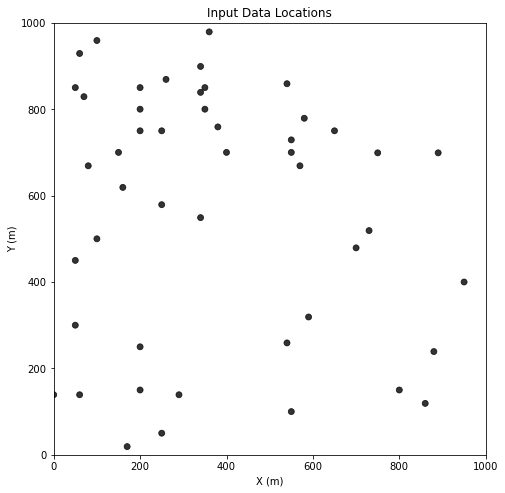

In [10]:
plt.subplot(111)   
im = plt.scatter(df['X'],df['Y'],s=None,c=df['null'],marker=None,cmap=cmap,norm=None,vmin=0,vmax=1.0,alpha=0.8,
        linewidths=0.8,edgecolors="black",)
plt.title('Input Data Locations')
plt.xlim(0, 1000); plt.ylim(0, 1000)
plt.xlabel('X (m)'); plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.5, wspace=0.3, hspace=0.3)
plt.show()

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [11]:
df.head(n = 13)

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,null
72,94,250.0,50.0,0.0,0.139637,0.347182,4747.274043,0.0
153,232,650.0,750.0,0.0,0.170732,10.720560,4535.625583,0.0
258,439,80.0,669.0,1.0,0.244345,3222.716042,2696.102930,0.0
56,73,200.0,150.0,0.0,0.167125,3.042590,5500.997419,0.0
303,521,60.0,929.0,1.0,0.216253,400.298484,3959.934912,0.0
374,645,750.0,699.0,0.0,0.159171,9.224292,5263.064063,0.0
333,571,340.0,549.0,0.0,0.170881,84.471492,2918.232227,0.0
1,2,50.0,850.0,1.0,0.237154,39.837129,3074.562617,0.0
54,71,200.0,250.0,1.0,0.188043,57.804784,4997.078597,0.0
311,535,250.0,579.0,1.0,0.215039,625.510541,2693.691341,0.0


#### Number of Effective Data

Let's try out our program for a variety of spatial continuity models.

* **100% nugget** - should have number of effective data equal to the number of data as they are all independent.

* **Zonal Anisotropy** - should have number of effective data equal to 1.0 as they are all perfectly redundnat.

* **Range of Fraction of Model Size** - should have a low number of effective data then increasing as the fraction decreases.

* **Other** - testing the code.


In [12]:
vario = GSLIB.make_variogram(nug=1.0,nst=1,it1=1,cc1=0.0,azi1=0.0,hmaj1=100,hmin1=100)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('100% Nugget:                  Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=1000000,hmin1=1000000)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('Zonal Anisotropy:             Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=1000,hmin1=1000)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('Range of Model Size:          Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=500,hmin1=500)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('Range of 1/2 Model Size:      Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=250,hmin1=250)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('Range of 1/4 Model Size:      Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=1,cc1=0.5,azi1=0.0,hmaj1=50,hmin1=50,it2=1,cc2=0.5,azi2=0.0,hmaj2=250,hmin2=250)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('Nested Variogram:             Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=1,cc1=0.5,azi1=0.0,hmaj1=50,hmin1=5,it2=1,cc2=0.5,azi2=0.0,hmaj2=250,hmin2=25)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print('Nested Anisotropic Variogram: Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')


100% Nugget:                  Number of effective data = 48 / 48.
Zonal Anisotropy:             Number of effective data = 1.0 / 48.
Range of Model Size:          Number of effective data = 1.99 / 48.
Range of 1/2 Model Size:      Number of effective data = 4.64 / 48.
Range of 1/4 Model Size:      Number of effective data = 13.24 / 48.
Nested Variogram:             Number of effective data = 22.36 / 48.
Nested Anisotropic Variogram: Number of effective data = 40.72 / 48.


#### Bootstrap with n-effective

This is an efficient method to calculate a bootstrap-based uncertainty model in a statistic while accounting for spatial data correlation

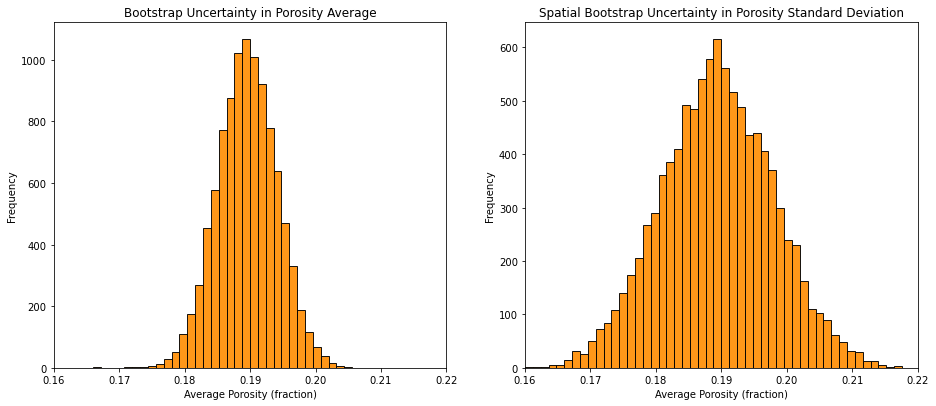

In [15]:
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=250,hmin1=250)
n_eff = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)

L = 10000                                      # set the number of realizations for uncertainty calculation
mean = np.zeros(L); spatial_mean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=None, cum_weights=None, k=len(df))
    spatial_samples = random.choices(df['Porosity'].values, weights=None, cum_weights=None, k=int(n_eff))

    mean[l] = np.average(samples)
    spatial_mean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,0.16,0.22,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(spatial_mean,0.16,0.22,False,False,50,None,'Average Porosity (fraction)','Spatial Bootstrap Uncertainty in Porosity Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   


Note the expansion of variance when we account for spatial continuity.  Experiment with the variogram model and rerun this result.  

* What happens when the range is increased?
* What happens when the nugget is added and increased?

#### Comments

This was a basic demonstration of spatial bootstrap with a comparison to traditional bootstrap with a developed function to calculate the number of effective data with LU-simulation.

Much more could be done, you could replace the statistics, average and standard deviation with any other statistics, for example P90, kurtosis, P13 etc. I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin